In [18]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from textblob import TextBlob





In [20]:
filterwarnings('ignore')
#uyarı mesajlarını gösterme
#satır ve sütünları kesmeden gösterir.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', None)

In [29]:

import nltk
nltk.download("stopwords")
sw = stopwords.words("english")

nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
## AMAÇ : Ürünlere gelen yorumları analiz ederek ve aldığı şikayetlere göre özelliklerini geliştirerek satışlar hakkında genel bilgi verir.
## Bu hedef doğrultusunda yorumlara duygu analizi yapılarak etiketlenecek ve etiketlenen veri ile sınıflandırma modeli oluşturulacaktır.


In [36]:
import pandas as pd

df = pd.read_excel("/content/amazon-ksms (1) (1).xlsx")
df.head()

## star : yıldız sayısı
## HelpFul :  yorumu faydalı bulan kişi sayısı
## Title : Yorum içeriğine verilen başlık, kısa yorum
## Review : Ürüne yapılan yorum

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [38]:
#text processing işlemi yapıyoruz,tüm metini küçük harfe çeviricez
df["Review"]=df["Review"].str.lower()
df["Review"][0:10]

,Review
0,happy with it
1,good quality material however the panels are m...
2,product was fun for bedroom windows.<br />imag...
3,lo unico que me gustaria es que sean un poco ...
4,great bang for the buck i can't believe the qu...
5,looks different then photo
6,was exactly what i was looking for. heavy mate...
7,"looking at the picture, i thought these curtai..."
8,much whiter than i thought it would be and was...
9,these are curtains just as the picture shows. ...


In [41]:
df["Review"]=df["Review"].str.replace("[^\\w\\s]"," ",regex=True)
df["Review"][0:10]

,Review
0,happy with it
1,good quality material however the panels are m...
2,product was fun for bedroom windows br imag...
3,lo unico que me gustaria es que sean un poco ...
4,great bang for the buck i can t believe the qu...
5,looks different then photo
6,was exactly what i was looking for heavy mate...
7,looking at the picture i thought these curtai...
8,much whiter than i thought it would be and was...
9,these are curtains just as the picture shows ...


In [42]:
## Sayısal ifadelerin çıkartılması

df["Review"] = df["Review"].str.replace("\\d","",regex=True)
df["Review"][0:10]

,Review
0,happy with it
1,good quality material however the panels are m...
2,product was fun for bedroom windows br imag...
3,lo unico que me gustaria es que sean un poco ...
4,great bang for the buck i can t believe the qu...
5,looks different then photo
6,was exactly what i was looking for heavy mate...
7,looking at the picture i thought these curtai...
8,much whiter than i thought it would be and was...
9,these are curtains just as the picture shows ...


In [43]:
## gereksiz  kelimelerin çıkartılması (stopwords)

df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df["Review"][0:10]

,Review
0,happy
1,good quality material however panels mis matched
2,product fun bedroom windows br imagery bit str...
3,lo unico que gustaria es que sean un poco mas ...
4,great bang buck believe quality material vibra...
5,looks different photo
6,exactly looking heavy material great price shi...
7,looking picture thought curtains would thinner...
8,much whiter thought would really expecting wan...
9,curtains picture shows rd set ambesonne curtai...


In [45]:
#en az tekrar eden kelimeleri çıkar
tmp_df = pd.Series(" ".join(df["Review"]).split()).value_counts()[-1000:]
tmp_df[0:100]  # ilk 100 tanesini göster


,count
obscure,1
dishes,1
wouldnt,1
learn,1
positives,1
origenal,1
negatives,1
thus,1
ambesome,1
bind,1


In [46]:
#Lemmatization, kelimenin anlamlı temel haline (sözlük formuna) dönüştürülmesidir. Bu sayede aynı anlamı taşıyan farklı biçimlerdeki kelimeler tek bir forma indirgenir.
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:

df["Review"] = df["Review"].apply(lambda x: " ".join([WordNetLemmatizer().lemmatize(word) for word in x.split()]))
df["Review"][0:10]


,Review
0,happy
1,good quality material however panel mi matched
2,product fun bedroom window br imagery bit stre...
3,lo unico que gustaria e que sean un poco ma la...
4,great bang buck believe quality material vibra...
5,look different photo
6,exactly looking heavy material great price shi...
7,looking picture thought curtain would thinner ...
8,much whiter thought would really expecting wan...
9,curtain picture show rd set ambesonne curtain ...


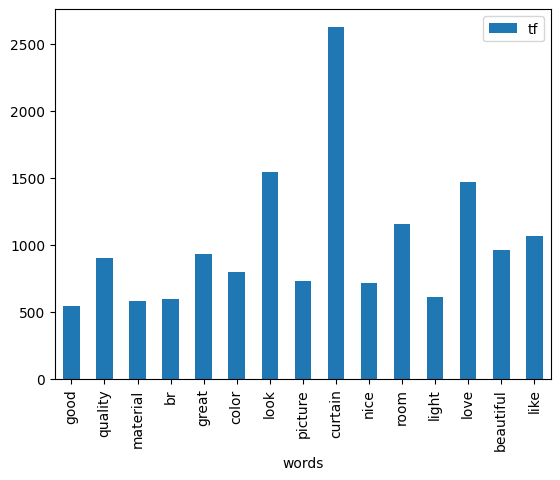

In [49]:
## GÖRSELLEŞTİRME:
## bar plot ile görselleştirme:

## Review" kelime frekanslarının hesaplanması

tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words" , "tf"]

tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

In [50]:
#nltk üzerinden duygu analizi kütüphanesi olan VADER lexicon indiriyoruz
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [52]:
sia = SentimentIntensityAnalyzer()
## polarite puanlarının hesaplanması:
df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"])[:10]

,Review
0,0.5719
1,0.4404
2,0.8519
3,0.0000
4,0.9042
5,0.0000
6,0.6249
7,0.9080
8,0.0000
9,0.7096


In [54]:

## polarite değerlerinin datasete eklenmesi

df["polarity_score"] = df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"])

df.head()

,Star,HelpFul,Title,Review,polarity_score
0,5,0,looks great,happy,0.5719
1,5,0,Pattern did not align between the two panels.,good quality material however panel mi matched,0.4404
2,5,0,Imagery is stretched. Still fun.,product fun bedroom window br imagery bit stre...,0.8519
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...,0.0000
4,5,0,Wow great purchase,great bang buck believe quality material vibra...,0.9042


In [56]:
## her değer için label ekleme
df["polarity_label"] = df.apply(lambda x: "pos" if x["polarity_score"] > 0 else "neg", axis=1)

df[df["polarity_score"] > 0][0:10]

,Star,HelpFul,Title,Review,polarity_score,polarity_label
0,5,0,looks great,happy,0.5719,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel mi matched,0.4404,pos
2,5,0,Imagery is stretched. Still fun.,product fun bedroom window br imagery bit stre...,0.8519,pos
4,5,0,Wow great purchase,great bang buck believe quality material vibra...,0.9042,pos
6,5,0,Perfect for spa room,exactly looking heavy material great price shi...,0.6249,pos
7,5,0,Actually better than expected,looking picture thought curtain would thinner ...,0.9080,pos
9,5,0,Pretty as a Picture,curtain picture show rd set ambesonne curtain ...,0.7096,pos
15,5,24,Fun and Elegant,love curtain printed polyester type material b...,0.9493,pos
16,3,3,Three Stars,love hem one smaller one,0.6369,pos
17,5,26,Very good quality and beautiful design,second time writing review amazon always alway...,0.9136,pos


In [58]:
## label değerinin encode edilmesi gerekmektedir.
from sklearn.preprocessing import LabelEncoder
df["polarity_label"] = LabelEncoder().fit_transform(df["polarity_label"])
df.head()

,Star,HelpFul,Title,Review,polarity_score,polarity_label
0,5,0,looks great,happy,0.5719,1
1,5,0,Pattern did not align between the two panels.,good quality material however panel mi matched,0.4404,1
2,5,0,Imagery is stretched. Still fun.,product fun bedroom window br imagery bit stre...,0.8519,1
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...,0.0000,0
4,5,0,Wow great purchase,great bang buck believe quality material vibra...,0.9042,1


In [66]:
#makine öğrenmesi hazırlık
#bağımlı -bağımsız değişken belirlenmesi,dataseti train ve test olarak ayırma
from sklearn.model_selection import train_test_split
X = df["Review"]
y = df["polarity_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
## tfıdf nesnesinin oluşturulması:
from sklearn.feature_extraction.text import TfidfVectorizer
# Use X_train instead of train_x
tf_idf_vec = TfidfVectorizer().fit(X_train)

In [67]:
#logistik regrasyon model oluşturma
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(tf_idf_vec.transform(X_train), y_train)

LogisticRegression()

In [69]:
from sklearn.metrics import accuracy_score, classification_report
prediction=log_reg.predict(tf_idf_vec.transform(X_test))
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

0.8993766696349065
              precision    recall  f1-score   support

           0       0.98      0.34      0.51       170
           1       0.89      1.00      0.94       953

    accuracy                           0.90      1123
   macro avg       0.94      0.67      0.73      1123
weighted avg       0.91      0.90      0.88      1123



In [72]:
#Cross-validation (çapraz doğrulama)
from sklearn.model_selection import cross_val_score
# Calculate TF-IDF values for X_train
x_train_tf_idf_word = tf_idf_vec.transform(X_train)
# Perform cross-validation
cross_val_score(log_reg, x_train_tf_idf_word, y_train, cv=5).mean()

np.float64(0.8937182342527554)